# GitOps Flow with MLRun

## Setup Project

In [2]:
import os
import yaml
from src import create_and_set_project, load_config, TrainConfig, EvaluateConfig, DeployConfig


project = create_and_set_project(
    name="cicd-flow",
    git_source="v3io:///bigdata/cicd-flow.zip",
)

config = load_config()

> 2023-09-18 23:36:57,974 [info] Project loaded successfully: {'project_name': 'cicd-flow'}
Exporting project as zip archive to v3io:///bigdata/cicd-flow.zip...


## Run Training Pipeline

In [4]:
train_config = TrainConfig(**config)

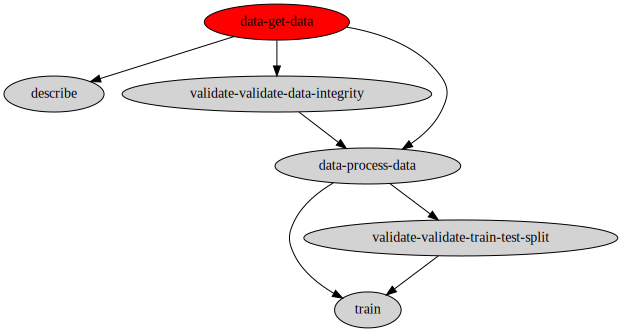

RuntimeError: Pipeline run status Failed

In [5]:
run_id = project.run(
    name="train",
    arguments=train_config.dict(),
    dirty=True,
    watch=True
)

## Run Evaluation Pipeline

In [ ]:
# model_path = project.list_models()
# train_set = ...
# test_set = ...

evaluate_config = EvaluateConfig(

## Run Deployment Pipeline

### Invoke Model

In [5]:
serving_fn = project.get_function("serving")
serving_fn.invoke('/v2/models/model/infer', {"inputs" : [[6.1, 2.8, 4.7, 1.2], [5.7, 3.8, 1.7, 0.3], [7.7, 2.6, 6.9, 2.3]]})

> 2023-08-17 21:06:26,931 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-liveops-demo-serving.default-tenant.svc.cluster.local:8080/v2/models/model/infer'}


RuntimeError: bad function response 400: ValueError: X has 4 features, but RandomForestClassifier is expecting 23 features as input.

### Simulate Traffic

MLRun real-time drift detection requires 10,000 events

In [ ]:
# Get serving function
serving_fn = project.get_function("serving")
model_name = "model"

# Get test set
df = project.get_artifact("train_test_set").to_dataitem().as_df()
display(df.head())

# Transform to list
# Get training set as list
iris_data = df.drop("label", axis=1).to_dict(orient="split")["data"]
iris_data[:5]

In [ ]:
import json
import logging
from random import choice

from tqdm.notebook import tqdm

# Suppress print messages
logging.getLogger(name="mlrun").setLevel(logging.WARNING)

# Simulate traffic using random elements from training set
for i in tqdm(range(12_000)):
    data_point = choice(iris_data)
    serving_fn.invoke(
        f"v2/models/{model_name}/infer", json.dumps({"inputs": [data_point]})
    )

# Resume normal logging
logging.getLogger(name="mlrun").setLevel(logging.INFO)